In [1]:
import os
import math
import numpy as np
import pandas as pd
from numpy.random import default_rng
import statistics
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
import scipy.integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as pyplot
from matplotlib import animation
from dataclasses import dataclass
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from collections import Counter

2024-06-11 21:35:03.375756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 21:35:03.410174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 21:35:03.410697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 21:35:04.214451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Helper functions

In [27]:
def split_dataset(acc, gyro, mag, states, size = 0.8):
    length = states.shape[0]

    train_size = int(np.floor(length * size))
    test_size = length - train_size

    rng = default_rng()
    train_idx = rng.choice(length, size=train_size, replace=False)
    test_idx = rng.choice(length, size=test_size, replace=False)
    
    return (
        acc[train_idx], acc[test_idx],
        gyro[train_idx], gyro[test_idx],
        mag[train_idx], mag[test_idx],
        states[train_idx], states[test_idx],
       )

def plot_graphs(kh, metric):
    for h in kh:
        pyplot.plot(h.history[metric])
        pyplot.plot(h.history['val_'+metric], '')
        pyplot.xlabel("Epochs")
        pyplot.ylabel(metric)
        pyplot.legend([metric, 'val_'+metric])

def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    pyplot.rc('font', size=12)
    fig, ax = pyplot.subplots(figsize=(15, 12))
    
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )

    pyplot.ylabel('Dejanski razred')
    pyplot.xlabel('Napovedani razred')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    b, t = pyplot.ylim()
    b += 0.5
    t -= 0.5
    pyplot.ylim(b, t)
    pyplot.show()
    
def evaluate_nn(act, pred, class_enc):
    actual = np.argmax(act, axis=1)
    predicted = np.argmax(pred, axis=1)

    precision, recall, f1, _ = score(actual, predicted)
    precision = [round(x, 4) for x in precision]
    recall = [round(x, 4) for x in recall]
    f1 = [round(x, 4) for x in f1]

    table = [precision, recall, f1]
    df = pd.DataFrame(table, columns = [class_enc.categories_[0]], index=['Točnost', 'Senzitivnost', 'F1'])

    print(df)
    print(
        "Povprečna točnost:", df.iloc[0].sum() / (df.iloc[0].size), "\n",
        "Povprečna senzitivnost:", df.iloc[1].sum() / (df.iloc[1].size), "\n",
        "Povprečni F1:", df.iloc[2].sum() / (df.iloc[2].size)
    )
    plot_cm(
        class_enc.inverse_transform(act),
        class_enc.inverse_transform(pred),
        [x.replace(' ', '\n') for x in enc.categories_[0]] #class_enc.categories_[0]
    )

    return df


state_mapping = {
    'STANDING': 'STOJEČI POLOŽAJ',
    'SITTING': 'SEDENJE',
    'WALKING': 'HOJA',
    'LYING': 'LEŽANJE',
    'SIT_DOWN': 'PREHOD STOJEČI POLOŽAJ - SEDENJE',
    'STAND_UP': 'PREHOD SEDENJE - STOJEČI POLOŽAJ ',
    'LYING_TO_SITTING': 'PREHOD LEŽANJE - SEDENJE',
    'LIE_DOWN': 'PREHOD SEDENJE - LEŽANJE'
}

## Priprava podatkov

In [28]:
SAMPLE_RATE = 50  # Hz
FILES = os.listdir("RecordedSamples")

FILE_NAMES = list(set(["_".join(f.split("_")[:2]) for f in FILES]))

In [29]:
timestamps = []
states = []
acc_data = []
gyro_data = []
mag_data = []

for FILE in FILE_NAMES:
    dfAcc = pd.read_csv(
        f'RecordedSamples/{FILE}_Accelerometer.csv',
        skiprows=4,
        names=("Date", "HostTimestamp", "NodeName", "NodeTimestamp",
            "RawData",  "X_axis",  "Y_axis",  "Z_axis", "NaN", "CurrentState")
    )
    dfAcc = dfAcc.drop('NaN', axis=1)
    dfAcc.sort_values('NodeTimestamp', inplace=True)

    dfGyro = pd.read_csv(
        f'RecordedSamples/{FILE}_Gyroscope.csv',
        skiprows=4,
        names=("Date", "HostTimestamp", "NodeName", "NodeTimestamp",
            "RawData",  "X_dps",  "Y_dps",  "Z_dps", "NaN", "CurrentState")
    )
    dfGyro = dfGyro.drop('NaN', axis=1)
    dfGyro.sort_values('NodeTimestamp', inplace=True)

    dfMag = pd.read_csv(
        f'RecordedSamples/{FILE}_Magnetometer.csv',
        skiprows=4,
        names=("Date", "HostTimestamp", "NodeName", "NodeTimestamp",
            "RawData",  "X_mGa",  "Y_mGa",  "Z_mGa", "NaN", "CurrentState")
    )
    dfMag = dfMag.drop('NaN', axis=1)
    dfMag.sort_values('NodeTimestamp', inplace=True)


    timestamp = (np.array(dfAcc.NodeTimestamp)-dfAcc.NodeTimestamp[0]) / 100

    gyroscope = np.array(dfGyro[["X_dps", "Y_dps", "Z_dps"]])
    accelerometer = np.array(dfAcc[["X_axis", "Y_axis", "Z_axis"]]) / 1000
    magnetometer = (np.array(dfMag[["X_mGa", "Y_mGa", "Z_mGa"]]) / 1000) * 0.0001 
    
    timestamps.append(timestamp)
    states.append(dfAcc.CurrentState)
    acc_data.append(accelerometer)
    gyro_data.append(gyroscope)
    mag_data.append(magnetometer)


In [30]:
total_length_minutes = sum([s.shape[0] for s in states]) / (SAMPLE_RATE * 60)
print(f"Skupna dolžina časovnih vrst: {round(total_length_minutes, 2)}min")

Skupna dolžina časovnih vrst: 244.3min


In [31]:
def create_dataset(x, y, time_steps=1, step=1):
    x_steps, y_steps = [], []
    for i in range(0, len(x) - time_steps, step):
        
        v = x[i: (i + time_steps)]
        labels = y[i: (i + time_steps)]
        x_steps.append(v)
        y_steps.append(
            state_mapping.get(
                statistics.mode(labels)
            ))
    return np.array(x_steps), np.array(y_steps).reshape(-1, 1)

TIME_STEPS = 50
STEP = 20

all_acceletometer_intervals = None
all_gyroscope_intervals = None
all_magnetometer_intervals = None

all_state_labels = None

for i, _ in enumerate(FILE_NAMES):
    acceleration_intervals, state_intervals = create_dataset(
        acc_data[i], states[i],
        TIME_STEPS, STEP
    )
    gyroscope_intervals, state_intervals = create_dataset(
        gyro_data[i], states[i],
        TIME_STEPS, STEP
    )
    magnetometer_intervals, state_intervals = create_dataset(
        mag_data[i], states[i],
        TIME_STEPS, STEP
    )

    all_state_labels = state_intervals if all_state_labels is None else np.append(all_state_labels, state_intervals, axis=0)
    all_acceletometer_intervals = acceleration_intervals if all_acceletometer_intervals is None else np.append(all_acceletometer_intervals, acceleration_intervals, axis=0)
    all_gyroscope_intervals = gyroscope_intervals if all_gyroscope_intervals is None else np.append(all_gyroscope_intervals, gyroscope_intervals, axis=0)
    all_magnetometer_intervals = magnetometer_intervals if all_magnetometer_intervals is None else np.append(all_magnetometer_intervals, magnetometer_intervals, axis=0)

    # print(all_acceletometer_intervals.shape, all_gyroscope_intervals.shape, 
    #     all_state_labels.shape)
    # all_acceletometer_intervals.append(acceleration_intervals)

### Porazdelitev razredov

<AxesSubplot:>

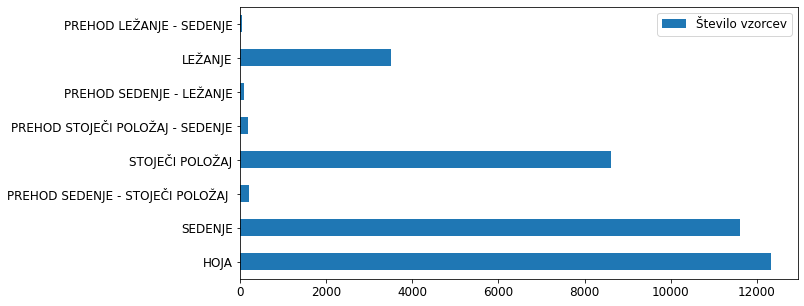

In [32]:
class_dist = Counter(all_state_labels[:, 0])
df = pd.DataFrame.from_dict(class_dist, orient='index', columns=['Število vzorcev'])
df.plot.barh(figsize=(10, 5))

### Združevanje prehodov stanj v svoj razred

In [9]:
# values_to_match = ['LYING_TO_SITTING', 'LIE_DOWN', 'SIT_DOWN', 'STAND_UP']
# mask = np.isin(all_state_labels, values_to_match)
# all_state_labels[mask] = np.repeat(['STATE_TRANSITION'], np.sum(mask))

Counter(all_state_labels[:, 0])

Counter({'HOJA': 12325,
         'SEDENJE': 11599,
         'PREHOD SEDENJE - STOJEČI POLOŽAJ ': 218,
         'STOJEČI POLOŽAJ': 8603,
         'PREHOD STOJEČI POLOŽAJ - SEDENJE': 185,
         'PREHOD SEDENJE - LEŽANJE': 94,
         'LEŽANJE': 3513,
         'PREHOD LEŽANJE - SEDENJE': 65})

### Delitev v učno in testno množico

In [33]:
(
    x_train_acc, x_test_acc,
    x_train_gyro, x_test_gyro,
    x_train_mag, x_test_mag, 
    y_train, y_test
) = split_dataset(
    all_acceletometer_intervals,
    all_gyroscope_intervals,
    all_magnetometer_intervals,
    all_state_labels,
    0.8
)

print(x_train_acc.shape, x_test_acc.shape)

# Normalizirane vrednosti
x_train_acc = x_train_acc / 4.0
x_test_acc = x_test_acc / 4.0

x_train_gyro = x_train_gyro / 720.0
x_test_gyro = x_test_gyro / 720.0

(29281, 50, 3) (7321, 50, 3)


In [34]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False) # sparse_output=False
enc = enc.fit(y_train)

y_train_final = enc.transform(y_train)
y_test_final = enc.transform(y_test)

# class_distribution = Counter(y_train[:, 0])
# total_samples = sum(class_distribution.values())
# class_weights = {cls: total_samples / count for cls, count in class_distribution.items()}
# weights = {i: class_weights[cls] for i, cls in enumerate(enc.categories_[0])}
# print(weights)

### Samo pospeškomer

In [10]:
x_train_joined = x_train_acc
x_test_joined = x_test_acc

### Kombinacija pospeškomera in žiroskopa

In [35]:
x_train_joined = np.concatenate((x_train_acc, x_train_gyro), axis=2)
x_test_joined = np.concatenate((x_test_acc, x_test_gyro), axis=2)

## Učenje

### 1 - LSTM model

In [36]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
    keras.layers.LSTM(
        units=128,
        input_shape=[x_train_joined.shape[1], x_train_joined.shape[2]]
        )
    )
)

model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train_final.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(x_train_joined, y_train_final,
                    validation_split=0.1,
                    batch_size=64,
                    epochs=40)

Epoch 1/40


2024-06-11 21:54:36.351724: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31622400 exceeds 10% of free system memory.


412/412 [==============================] - 20s 40ms/step - loss: 1.0039 - acc: 0.5479 - precision_2: 0.6705 - recall_2: 0.3585 - val_loss: 0.7213 - val_acc: 0.7388 - val_precision_2: 0.7736 - val_recall_2: 0.6555
Epoch 2/40
412/412 [==============================] - 16s 39ms/step - loss: 0.7349 - acc: 0.7175 - precision_2: 0.7598 - recall_2: 0.6471 - val_loss: 0.6988 - val_acc: 0.7296 - val_precision_2: 0.7731 - val_recall_2: 0.6654
Epoch 3/40
412/412 [==============================] - 16s 38ms/step - loss: 0.7177 - acc: 0.7229 - precision_2: 0.7648 - recall_2: 0.6610 - val_loss: 0.7198 - val_acc: 0.7538 - val_precision_2: 0.8124 - val_recall_2: 0.6859
Epoch 4/40
412/412 [==============================] - 16s 38ms/step - loss: 0.5215 - acc: 0.7956 - precision_2: 0.8204 - recall_2: 0.7685 - val_loss: 0.3771 - val_acc: 0.8522 - val_precision_2: 0.8622 - val_recall_2: 0.8419
Epoch 5/40
412/412 [==============================] - 15s 36ms/step - loss: 0.3876 - acc: 0.8386 - precision_2: 0.8

### 2 - Navadna nevronska mreža

In [76]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(x_train_joined.shape[1], x_train_joined.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train_final.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(x_train_joined, y_train_final,
                    validation_split=0.1,
                    batch_size=64,
                    epochs=30,
                    shuffle=True)

Epoch 1/30
412/412 [==============================] - 1s 2ms/step - loss: 0.8043 - acc: 0.6823 - precision_4: 0.7849 - recall_4: 0.5183 - val_loss: 0.3954 - val_acc: 0.8498 - val_precision_4: 0.8582 - val_recall_4: 0.8429
Epoch 2/30
412/412 [==============================] - 1s 2ms/step - loss: 0.4124 - acc: 0.8329 - precision_4: 0.8551 - recall_4: 0.8093 - val_loss: 0.3269 - val_acc: 0.8672 - val_precision_4: 0.8699 - val_recall_4: 0.8604
Epoch 3/30
412/412 [==============================] - 1s 2ms/step - loss: 0.3568 - acc: 0.8543 - precision_4: 0.8661 - recall_4: 0.8394 - val_loss: 0.2898 - val_acc: 0.8921 - val_precision_4: 0.9014 - val_recall_4: 0.8867
Epoch 4/30
412/412 [==============================] - 1s 2ms/step - loss: 0.3314 - acc: 0.8638 - precision_4: 0.8731 - recall_4: 0.8543 - val_loss: 0.2788 - val_acc: 0.8853 - val_precision_4: 0.8925 - val_recall_4: 0.8761
Epoch 5/30
412/412 [==============================] - 1s 2ms/step - loss: 0.3147 - acc: 0.8720 - precision_4: 0.

### 3 - Konvolucijska nevronska mreža

In [72]:
model = keras.Sequential()

model.add(keras.layers.Input((x_train_joined.shape[1], x_train_joined.shape[2])))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv1D(filters=128, kernel_size=6, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(y_train_final.shape[1], activation="softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()]
)

history = model.fit(x_train_joined, y_train_final,
                  validation_split=0.1,
                   batch_size=64,
                   epochs=10)

Epoch 1/10
412/412 [==============================] - 8s 16ms/step - loss: 0.3510 - acc: 0.8733 - precision_20: 0.8959 - recall_20: 0.8451 - val_loss: 1.7097 - val_acc: 0.3312 - val_precision_20: 0.3528 - val_recall_20: 0.3114
Epoch 2/10
412/412 [==============================] - 6s 15ms/step - loss: 0.2586 - acc: 0.8970 - precision_20: 0.9048 - recall_20: 0.8899 - val_loss: 0.7496 - val_acc: 0.7159 - val_precision_20: 0.7197 - val_recall_20: 0.7125
Epoch 3/10
412/412 [==============================] - 6s 15ms/step - loss: 0.2423 - acc: 0.9038 - precision_20: 0.9102 - recall_20: 0.8981 - val_loss: 0.9558 - val_acc: 0.5954 - val_precision_20: 0.6331 - val_recall_20: 0.5579
Epoch 4/10
412/412 [==============================] - 7s 16ms/step - loss: 0.2270 - acc: 0.9110 - precision_20: 0.9167 - recall_20: 0.9068 - val_loss: 0.3121 - val_acc: 0.8566 - val_precision_20: 0.8639 - val_recall_20: 0.8535
Epoch 5/10
412/412 [==============================] - 6s 16ms/step - loss: 0.2149 - acc: 0.9

(0.0, 1.0426797889173032)

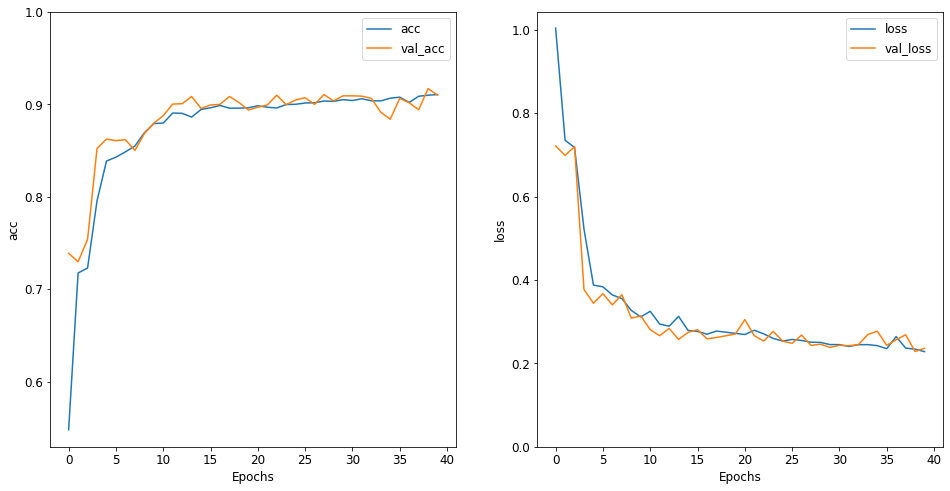

In [37]:
pyplot.figure(figsize=(16, 8))
pyplot.subplot(1, 2, 1)
plot_graphs([history], 'acc')
pyplot.ylim(None, 1)
pyplot.subplot(1, 2, 2)
plot_graphs([history], 'loss')
pyplot.ylim(0, None)

## Evalvacija

229/229 [==============================] - 3s 9ms/step
                HOJA LEŽANJE PREHOD LEŽANJE - SEDENJE  \
Točnost       0.9939  0.9776                   0.7692   
Senzitivnost  0.9919  1.0000                   0.5882   
F1            0.9929  0.9887                   0.6667   

             PREHOD SEDENJE - LEŽANJE PREHOD SEDENJE - STOJEČI POLOŽAJ   \
Točnost                        0.6667                            0.6596   
Senzitivnost                   0.2857                            0.7045   
F1                             0.4000                            0.6813   

             PREHOD STOJEČI POLOŽAJ - SEDENJE SEDENJE STOJEČI POLOŽAJ  
Točnost                                0.6562  0.8295          0.8921  
Senzitivnost                           0.4884  0.9345          0.7429  
F1                                     0.5600  0.8789          0.8107  
Povprečna točnost: 0.8056 
 Povprečna senzitivnost: 0.7170125 
 Povprečni F1: 0.7474000000000001


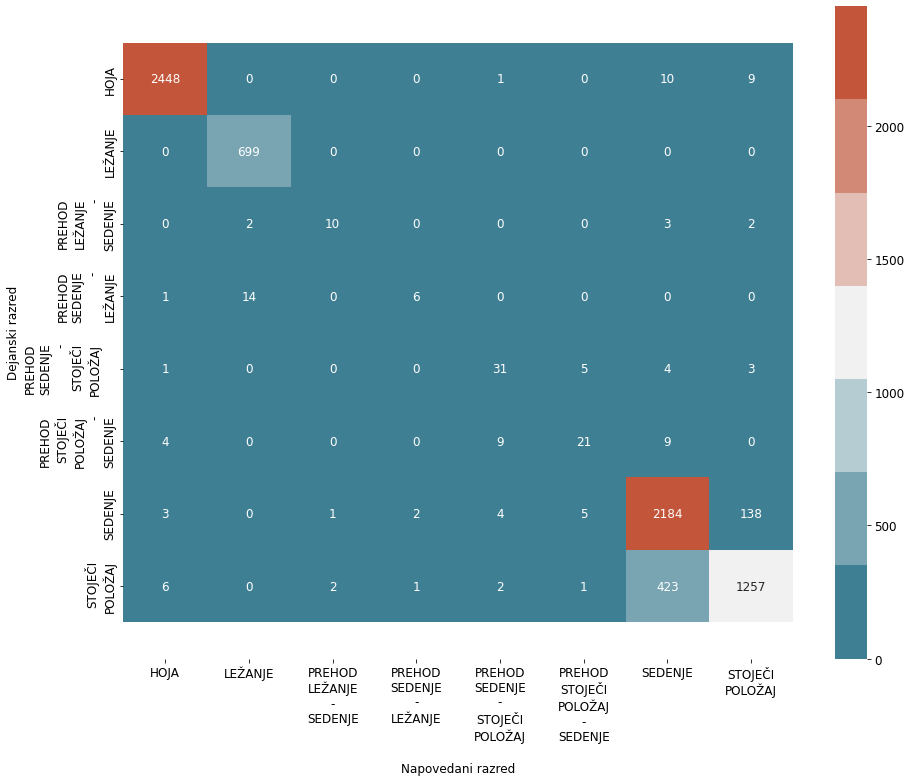

In [38]:
y_pred = model.predict(x_test_joined)
model_evaluation = evaluate_nn(y_test_final, y_pred, enc)

### Shranjevanje modela

In [79]:
run_model = tf.function(lambda x: model(x))

BATCH_SIZE = 1
STEPS = x_train_joined.shape[1]
INPUT_SIZE = x_train_joined.shape[2]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

MODEL_DIR = "model_src/tmp"
# model.save(MODEL_DIR, save_format="tf", signatures=concrete_func) # DEPRECATED
model.export(filepath=MODEL_DIR)

INFO:tensorflow:Assets written to: model_src/tmp/assets


INFO:tensorflow:Assets written to: model_src/tmp/assets


Saved artifact at 'model_src/tmp'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 50, 6)
  Returns:
    float32 Tensor, shape=(None, 8)


### Float32 model

2024-06-02 16:46:56.902168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-06-02 16:46:56.902188: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-06-02 16:46:56.902338: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model_src/tmp
2024-06-02 16:46:56.902623: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-06-02 16:46:56.902632: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model_src/tmp
2024-06-02 16:46:56.903416: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-06-02 16:46:56.916183: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model_src/tmp
2024-06-02 16:46:56.921377: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 19041 microsecon

                HOJA LEŽANJE PREHOD LEŽANJE - SEDENJE  \
Točnost       0.9979  0.9945                   0.8182   
Senzitivnost  0.9943  0.9972                   0.8182   
F1            0.9961  0.9958                   0.8182   

             PREHOD SEDENJE - LEŽANJE PREHOD SEDENJE - STOJEČI POLOŽAJ   \
Točnost                        0.8000                            0.7391   
Senzitivnost                   0.5714                            0.6800   
F1                             0.6667                            0.7083   

             PREHOD STOJEČI POLOŽAJ - SEDENJE SEDENJE STOJEČI POLOŽAJ  
Točnost                                0.8696  0.8326          0.8866  
Senzitivnost                           0.6061  0.9346          0.7557  
F1                                     0.7143  0.8806          0.8159  
Povprečna točnost: 0.8673124999999999 
 Povprečna senzitivnost: 0.7946875 
 Povprečni F1: 0.8244875


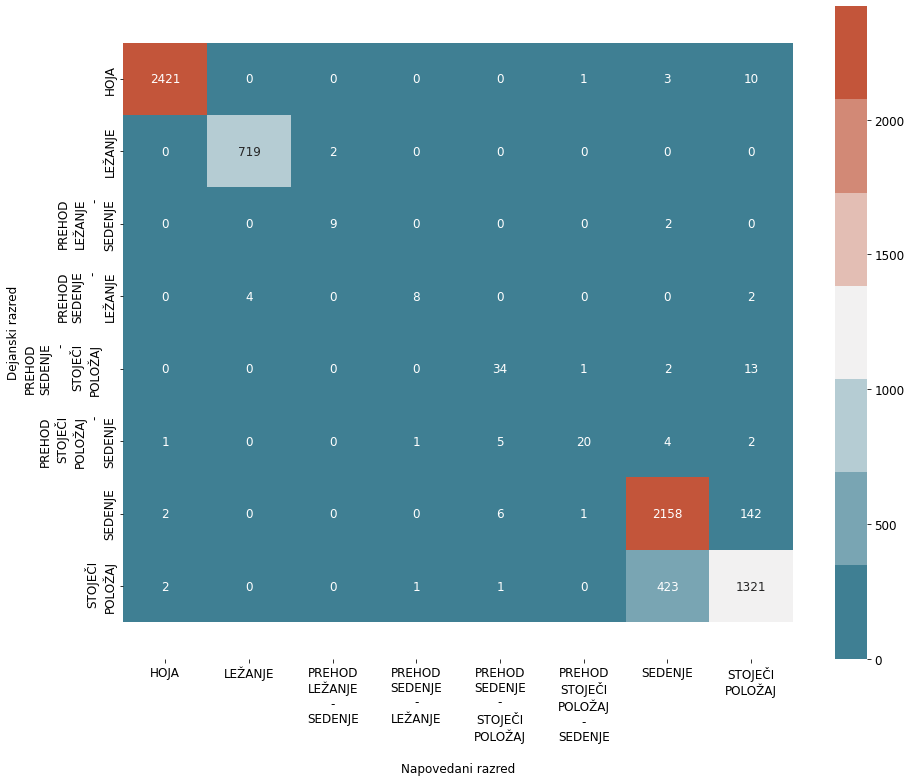

,HOJA,LEŽANJE,PREHOD LEŽANJE - SEDENJE,PREHOD SEDENJE - LEŽANJE,PREHOD SEDENJE - STOJEČI POLOŽAJ,PREHOD STOJEČI POLOŽAJ - SEDENJE,SEDENJE,STOJEČI POLOŽAJ
Točnost,0.9979,0.9945,0.8182,0.8000,0.7391,0.8696,0.8326,0.8866
Senzitivnost,0.9943,0.9972,0.8182,0.5714,0.6800,0.6061,0.9346,0.7557
F1,0.9961,0.9958,0.8182,0.6667,0.7083,0.7143,0.8806,0.8159


In [80]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
float32_tflite_model = converter.convert()

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=float32_tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
float32_predicted = np.empty(y_test_final.shape)

for i in range(x_test_joined.shape[0]):
    interpreter.set_tensor(input_details[0]["index"], tf.cast(x_test_joined[i:i+1, :, :], tf.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    float32_predicted[i] = result

    interpreter.reset_all_variables()

evaluate_nn(y_test_final, float32_predicted, enc)

In [81]:
float32_model_size = open("model_src/float32_model.tflite",  "wb").write(float32_tflite_model)
print("Model size {:.2f} KB".format(float32_model_size / 1024))

Model size 435.94 KB


### INT8 model

2024-06-02 16:47:05.211817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-06-02 16:47:05.211843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-06-02 16:47:05.212004: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model_src/tmp
2024-06-02 16:47:05.212440: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-06-02 16:47:05.212456: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model_src/tmp
2024-06-02 16:47:05.213463: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-06-02 16:47:05.228558: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model_src/tmp
2024-06-02 16:47:05.235145: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 23142 microsecon

INPUT SCALE: 0.0032578432001173496 
ZERO_POINT: -22
                HOJA LEŽANJE PREHOD LEŽANJE - SEDENJE  \
Točnost       0.9979  0.9945                   0.8182   
Senzitivnost  0.9955  0.9972                   0.8182   
F1            0.9967  0.9958                   0.8182   

             PREHOD SEDENJE - LEŽANJE PREHOD SEDENJE - STOJEČI POLOŽAJ   \
Točnost                        0.8889                            0.6981   
Senzitivnost                   0.5714                            0.7400   
F1                             0.6957                            0.7184   

             PREHOD STOJEČI POLOŽAJ - SEDENJE SEDENJE STOJEČI POLOŽAJ  
Točnost                                0.9130  0.8279          0.8776  
Senzitivnost                           0.6364  0.9272          0.7466  
F1                                     0.7500  0.8748          0.8068  
Povprečna točnost: 0.8770125 
 Povprečna senzitivnost: 0.8040625 
 Povprečni F1: 0.83205


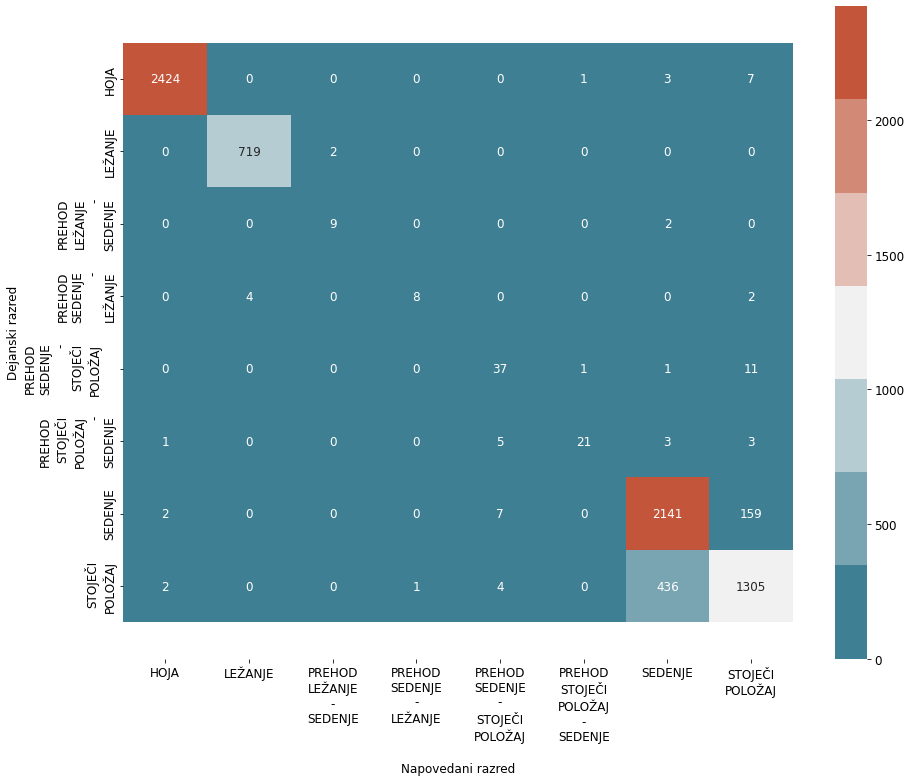

In [82]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(tf.cast(x_test_joined, tf.float32)).batch(1).take(1000):
    yield [input_value]

def quantization_int8(value):
    return tf.cast(value / input_scale + input_zero_point, tf.int8)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

converter.representative_dataset = representative_data_gen
int8_tflite_model = converter.convert()

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=int8_tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_scale, input_zero_point = input_details[0]["quantization"]

print("INPUT SCALE:", input_scale, "\nZERO_POINT:", input_zero_point)

int8_predicted = np.empty(y_test_final.shape)

for i in range(x_test_joined.shape[0]):
    q_int8 = quantization_int8(x_test_joined[i:i+1, :, :])
    interpreter.set_tensor(input_details[0]["index"], q_int8)
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    int8_predicted[i] = result
   
    interpreter.reset_all_variables()

int8_model_evaluation = evaluate_nn(y_test_final, int8_predicted, enc)

In [83]:
int8_model_size = open("model_src/int8_model.tflite",  "wb").write(int8_tflite_model)
print("Model size {:.2f} KB".format(int8_model_size / 1024))

Model size 112.35 KB


In [62]:
model_evaluation - int8_model_evaluation

,HOJA,LEŽANJE,PREHOD LEŽANJE - SEDENJE,PREHOD SEDENJE - LEŽANJE,PREHOD SEDENJE - STOJEČI POLOŽAJ,PREHOD STOJEČI POLOŽAJ - SEDENJE,SEDENJE,STOJEČI POLOŽAJ
Točnost,0.0007,-0.0015,-0.0441,0.1402,0.0138,0.0100,-0.0633,-0.0067
Senzitivnost,0.0000,0.0210,0.0000,-0.0500,-0.0625,0.0333,0.0080,-0.1603
F1,0.0004,0.0101,-0.0227,0.1121,-0.0406,0.0242,-0.0393,-0.1383


# Generiranje datotek za izvajanje na STM32 razvojni plošči

In [84]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

int8_source_text, int8_header_text = convert_bytes_to_c_source(int8_tflite_model,  "int8_model")
float32_source_text, float32_header_text = convert_bytes_to_c_source(float32_tflite_model,  "float32_model")

with open('model_src/int8_model.h',  'w')  as  file:
    file.write(int8_header_text)

with open('model_src/int8_model.cc',  'w')  as  file:
    file.write(int8_source_text)

with open('model_src/float32_model.h',  'w')  as  file:
    file.write(float32_header_text)

with open('model_src/float32_model.cc',  'w')  as  file:
    file.write(float32_source_text)